# Поведение пользователей приложения

**Описание проекта:**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Цель исследования:**

Нужно разобраться, как ведут себя пользователи мобильного приложения. Для этого необходимо выполнить следующие действия:

1. Изучить воронку продаж, чтобы узнать путь пользователей до покупки товара в приложении. 
2. Выяснить долю тех, кто совершает покупку, и тех, кто "застревает" на предыдущих шагах. Выяснить причину, по которой пользователям не удается дойти до покупки товара.
3. Исследовать результаты A/A/B-эксперимента, чтобы выяснить, какой шрифт лучше подходит для приложения.

**Ход исследования:**

Данные о действиях пользователей я получу из файла ```/datasets/logs_exp.csv```. О качестве исходных данных ничего не известно, поэтому понадобится обзор данных перед тем, как приступить к анализу.

На этапе ознакомления с данными мне необходимо убедиться в качестве полученных данных. На этапе предобработки необходимо подготовить данные к дальнейшему анализу. При наличие пропусков в данных я их обработаю. Затем, я проверю данные на аномалии и дубликаты, чтобы результаты анализа A/A/B-эксперимента были корректными для принятия дальнейших решений об изменении шрифта в мобильном приложении.

На этапе анализа событий в логе я найду общее количество событий, количество уникальных пользователей и среднее количество событий на одного пользователя. Также необходимо обработать данные. Если устаревшие данные будут составлять меньше 5% от общей выборки, я их удалю. Во время изучения воронки событий необходимо найти, на каком шаге теряется больше всего пользователей. Помимо этого, я вычислю долю пользователей, которых доходят от первого события до оплаты.

По результатам анализа эксперимента необходимо сделать выводы об остановке теста или о его продолжении. Также я проверю наличие статистически значимых различий между А-группами и В-группой. 

В конце проекта необходимо сформулировать общий вывод по всей проделанной работе.

Таким образом, моё исследование пройдет в 6 этапов:
- Ознакомление с исходными данными
- Предобработка данных
- Анализ событий в логе
- Изучение воронки событий
- Анализ результатов эксперимента
- Написание общего вывода

### Ознакомление с исходными данными

#### Импорт библиотек и создание датафрейма с данными из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import datetime as dt
from scipy import stats as st
import math as mth

warnings.filterwarnings('ignore')

In [2]:
try:
    logs_data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs_data = pd.read_csv('logs_exp.csv', sep='\t')

#### Изучение полученных данных

In [3]:
print(display(logs_data.head())) # предварительный просмотр

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


None


In [4]:
print(logs_data.info()) # вывод информации о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


In [5]:
print('Количество дубликатов:', logs_data.duplicated().sum())

Количество дубликатов: 413


In [6]:
print(logs_data.isna().sum())

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


#### Вывод:

На этом этапе были обнаружены дубликаты в данных. Названия столбцов не соответствуют змеиному регистру, тип данных столбца с датой не является типом datetime. Необходимо провести предобработку данных для получения корректных результатов исследования. Пропусков в данных не обнаружено.

### Предобработка данных

***Обработка дубликатов в данных:***

In [7]:
# Вычислим процент дубликатов относительно выборки
print('Процент дубликатов:', logs_data.duplicated().sum() / logs_data['EventName'].count() * 100)

# Удалим дубликаты в данных с помощью drop_duplicates()
logs_data = logs_data.drop_duplicates().reset_index(drop=True)

# Проверка удаления
print('Количество дубликатов:', logs_data.duplicated().sum())

Процент дубликатов: 0.16917493425526162
Количество дубликатов: 0


***Приведение названий столбцов к змеиному регистру:***

In [8]:
# Вывод названий столбцов
print(logs_data.columns)

# Преобразование названий столбцов
logs_data = logs_data.rename(columns={
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id_hash',
    'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'})

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')


***Изменение типа данных для столбца с датой:***

In [9]:
# Вывод предварительной информации
print(logs_data.info())

# Добавление столбца с датой и временем
logs_data['date_time'] = pd.to_datetime(logs_data['event_timestamp'], unit='s')

# Создание столбца с датой
logs_data['date'] = pd.to_datetime(logs_data['date_time']).dt.floor('1D')

# Вывод 5 строк для проверки
logs_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB
None


,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


***Проверим попадание пользователей сразу в несколько групп:***

In [10]:
# Используем метод np.intersect1d, который вернет уникальных пользователей, попавших в оба массива
display(np.intersect1d(
    logs_data.query('exp_id == "246"')['device_id_hash'].unique(), 
    logs_data.query('exp_id == "247"')['device_id_hash'].unique()))

display(np.intersect1d(
    logs_data.query('exp_id == "246"')['device_id_hash'].unique(), 
    logs_data.query('exp_id == "248"')['device_id_hash'].unique()))

display(np.intersect1d(
    logs_data.query('exp_id == "247"')['device_id_hash'].unique(), 
    logs_data.query('exp_id == "248"')['device_id_hash'].unique()))

array([], dtype=int64)

array([], dtype=int64)

array([], dtype=int64)

#### Вывод:

- Были удалены дубликаты, так как они составляли меньше 1% от общего объема данных. 
- Названий столбцов были приведены к змеиному регистру. 
- Добавлены 2 столбца:
    - Столбец с датой и временем
    - Столбец с датой (без времени)
- Пользователей, попавших сразу в несколько групп, не обнаружено.

### Анализ событий в логе

#### Посчитаем общее количество событий в логе:

In [11]:
# Применим метод shape. Он выводит так: (кол-во строк, кол-во столбцов)
total_events = logs_data['event_name'].shape[0]
print('Всего событий в логе:', total_events)

Всего событий в логе: 243713


#### Посчитаем общее количество пользователей в логе:

In [12]:
# Применим метод nunique, чтобы найти количество уникальных пользователей
total_users = logs_data['device_id_hash'].nunique()

print('Всего пользователей в логе:', total_users)

Всего пользователей в логе: 7551


#### Посчитаем, сколько в среднем событий приходится на пользователя:

In [13]:
events_per_user = logs_data.groupby('device_id_hash')['event_name'].count()

print('Среднее количество событий на пользователя:', '{:.2f}'.format(events_per_user.mean()))

Среднее количество событий на пользователя: 32.28


#### Найдем период, в течение которого были собраны данные:

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: date_time, dtype: object


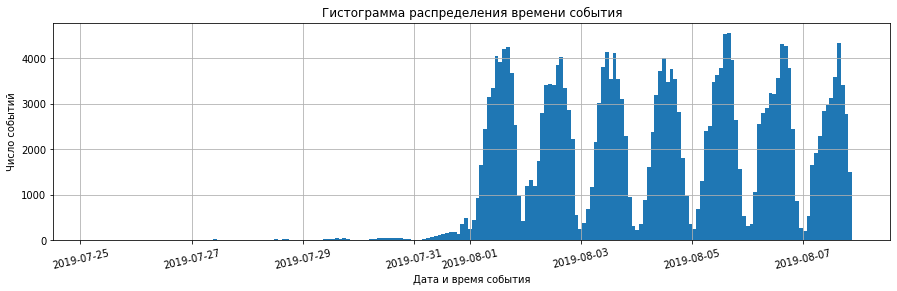

In [14]:
# Получим информацию о столбце с датой и временем событий
print(logs_data['date_time'].describe())

# Зададим параметры графика
plt.figure(figsize=(15,4))
logs_data['date_time'].hist(bins=200)
plt.title('Гистограмма распределения времени события')
plt.xticks(rotation=13)
plt.ylabel('Число событий')
plt.xlabel('Дата и время события')
plt.show()

Первые события появились 2019-07-25, но по гистограмме видно, что до 2019-08-01 сохранено очень мало информации о событиях. В последующие же даты дневные распределения значительно больше.

Нельзя быть уверенным, что у нас одинаково полные данные за весь период. Мы располагаем полными данными с 1 по 7 августа 2019 включительно.

Необходимо выбрать точное время, чтобы отбросить старые данные. Возьмем за границу 31 июля для того, чтобы изучить период первой недели августа более детально.

#### Очистим данные от дней, для которых не имеется полной информации:

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: date_time, dtype: object


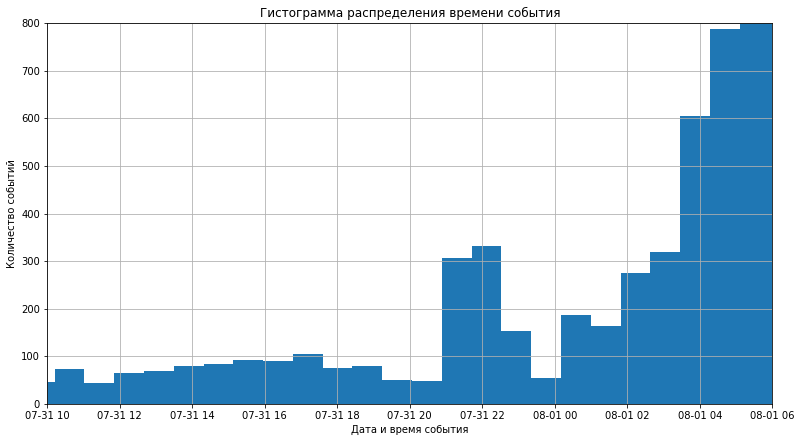

In [15]:
print(logs_data['date_time'].describe())

plt.figure(figsize=(13,7))
logs_data['date_time'].hist(bins=400)

plt.title('Гистограмма распределения времени события')
plt.ylabel('Количество событий')
plt.xlabel('Дата и время события')
plt.xlim(dt.datetime(2019, 7, 31, 10, 0), dt.datetime(2019, 8, 1, 6, 0))
plt.ylim(0, 800)

plt.show()

С помощью гистограммы мы можем выяснить, что резкий всплеск количества событий произошел 31 июля в 21:00. Скорее всего, это связано со временем запуска теста. Данные до этого времени необходимо очистить, чтобы их не анализировать.

In [16]:
# Удаление из датафрейма старых данных
logs_data = logs_data[logs_data['date_time'] >= dt.datetime(2019, 7, 31, 21, 0)]

#### Посчитаем количество событий и пользователей, которые были удалены после обработки старых данных:

In [17]:
# Подсчет количества событий после удаления старых данных
total_events_new = len(logs_data)
print('Всего событий в логе: ', total_events_new)

# Подсчет количества уникальных пользователей после удаления старых данных
total_users_new = logs_data['device_id_hash'].nunique()
print('Всего уникальных пользователей в логе: ', total_users_new)

print('Процент событий, которые были удалены после обработки старых данных: {:.2%}'.format(total_events/total_events_new-1))
print('Процент пользователей, которые были удалены после обработки старых данных: {:.2%}'.format(total_users/total_users_new-1))

Всего событий в логе:  241724
Всего уникальных пользователей в логе:  7538
Процент событий, которые были удалены после обработки старых данных: 0.82%
Процент пользователей, которые были удалены после обработки старых данных: 0.17%


Доля удаленных данных не превышает 1%, можно продолжать исследование.

#### Проверим, что есть пользователи из всех трёх экспериментальных групп:

In [18]:
logs_data['exp_id'].value_counts()

248    84875
246    79556
247    77293
Name: exp_id, dtype: int64

Пользователи из всех трех экспериментальных групп у нас есть.

По данным из таблицы можно сделать вывод, что пользователи распределены равномерно по трем экспериментальным группам.

#### Вывод:

После проведенного анализа событий в логе было выяснено:

- Общее количество событий в логе - 243713
- Всего пользователей в логе - 7551
- Среднее количество событий на пользователя - 32

В процессе анализа было обнаружено, что 31 июля 2019 года в 21:00 произошел всплеск количества событий. Это может быть связано с запуском теста. Данные, которые были до этого времени, удалены. В итоге получились следующие результаты показателей:

- Общее количество событий в логе после удаления старых данных - 241724
- Всего пользователей в логе после удаления старых данных - 7538
- Доля удаленных данных о событиях от общего количества событий - 0.82%
- Доля удаленных пользователей от общего числа пользователей - 0.17%

Данные были очищены с потерей менее 1% объема. Пользователи распределены равномерно по трем экспериментальным группам. Можно приступать к изучению воронки событий.

### Изучение воронки событий

#### Посмотрим, какие события есть в логах и как часто они встречаются:

In [19]:
logs_data['event_name'].value_counts()

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event_name, dtype: int64

По выведенной таблице можно определить, какие действия совершает пользователей:

1. MainScreenAppear - пользователь зашел на главную страницу
2. OffersScreenAppear - пользователь зашел на страницу предложений
3. CartScreenAppear - пользователь зашел на страницу с корзиной
4. PaymentScreenSuccessful - пользователю показана страница об успешной оплате
5. Tutorial - пользователь зашел на страницу с инструкцией

#### Посчитаем, сколько пользователей совершали каждое из этих событий, а также долю пользователей, которые хоть раз совершали событие:

***Посчитаем, сколько пользователей совершали каждое из событий:***

In [20]:
logs_data.groupby('event_name').count().sort_values(by='device_id_hash', ascending=False)['device_id_hash']

event_name
MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: device_id_hash, dtype: int64

***Посчитаем долю пользователей, которые хоть раз совершали событие:***

In [21]:
users_per_event = (
    logs_data
    .pivot_table(index='event_name', values='device_id_hash', aggfunc=lambda x: x.nunique())
    .sort_values('device_id_hash', ascending=False)
)
users_per_event.columns = ['users_cnt']
(users_per_event / len(logs_data['device_id_hash'].unique())).style.format('{:.2f}')

,users_cnt
event_name,
MainScreenAppear,0.98
OffersScreenAppear,0.61
CartScreenAppear,0.50
PaymentScreenSuccessful,0.47
Tutorial,0.11


#### Построим воронку событий:

In [22]:
data = users_per_event.pivot_table(index='event_name', values='users_cnt')
data = data.sort_values(by='users_cnt', ascending=False)
data['step'] = data / data.shift(1, fill_value=1) 
data = data.fillna(100)

first_step = data['users_cnt'].max()
last_step = data['users_cnt'][3]

In [23]:
print(data['step'])
print('Доля пользователей, которые не попали на главный экран приложения:', '{:.2%}'.format(1 - (data['step'][0] / logs_data['device_id_hash'].nunique())))
print()
print('Доля пользователей, которая доходит от первого события до оплаты:', '{:.2%}'.format(last_step / first_step))

event_name
MainScreenAppear           7423.000000
OffersScreenAppear            0.619291
CartScreenAppear              0.812704
PaymentScreenSuccessful       0.947537
Tutorial                      0.238136
Name: step, dtype: float64
Доля пользователей, которые не попали на главный экран приложения: 1.53%

Доля пользователей, которая доходит от первого события до оплаты: 47.69%


Примерно 1.5% пользователей не попадает на главный экран приложения. Необходимо сообщить об этом техническому отделу.

При переходе с главной страницы приложения теряются 38% пользователей, до оплаты доходят 48% от изначального количества пользователей.

#### Вывод:

- Изучены типы событий и их количество.
- По воронке событий было сделаны следующие выводы:
    - Примерно 1.53% пользователей не попадает на главный экран. Вероятно, что у них возникают технические неполадки.
    - На первом шаге теряется больше всего пользователей: 38% от изначальных пользователей.
    - От первого события до оплаты доходит 48% от изначального количества пользователей.

### Анализ результатов эксперимента

#### Выведем данные о количестве пользователей в каждой экспериментальной группе:

In [24]:
logs_data.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2517
248    2537
Name: device_id_hash, dtype: int64

В группе 246 находится 2483 пользователя, в группе 247 - 2516 пользователей, в группе 248 - 2535 пользователей. В каждой экспериментальной группе примерно одинаковое число пользователей.

Проверим для каждого событий, будет ли отличие между экспериментальными группами статистически достоверным.

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза: Доли уникальных пользователей по событию для сравниваемых групп равны.

- Альтернативная гипотеза: Доли уникальных пользователей по событию для сравниваемых групп отличаются.

#### Проверим, находят ли статистические критерии разницу между выборками 246 и 247:

In [25]:
data_246 = logs_data.query('exp_id == 246').groupby('exp_id')['device_id_hash'].nunique().reset_index()
data_247 = logs_data.query('exp_id == 247').groupby('exp_id')['device_id_hash'].nunique().reset_index()

In [26]:
diff = 1 - data_246.iloc[0]['device_id_hash'] / data_247.iloc[0]['device_id_hash']
print('Разница между выборками 246 и 247 - {:.2%}'.format(diff))

Разница между выборками 246 и 247 - 1.31%


Между выборками 246 и 247 разница небольшая (примерно 1%), это приемлемо для контрольных групп.

#### Посмотрим, сколько пользователей совершали каждое событие в каждой экспериментальной группе:

In [27]:
logs_data.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique')

exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1239,1231
MainScreenAppear,2450,2479,2494
OffersScreenAppear,1542,1524,1531
PaymentScreenSuccessful,1200,1158,1182
Tutorial,278,284,281


Самое популярное событие - MainScreenAppear. Тут большой разницы между количеством пользователей нет. В 246 группе больше всего событий оплаты (PaymentScreenSuccessful).


Сформулируем гипотезы:

- Нулевая гипотеза: Доли уникальных пользователей по событию для сравниваемых групп равны.

- Альтернативная гипотеза: Доли уникальных пользователей по событию для сравниваемых групп отличаются.

Для проверки гипотез применим z-тест (z-критерий Фишера). Он применяется для проверки равенства средних значений при известной дисперсии генеральной совокупности или при оценке выборочного среднего стандартизованных значений.

Создадим функцию, считающую статистическую значимость между группами. Датафрейм будем обрабатывать внутри функции, группы будем передавать в виде списка.

Пороговое значение alpha примем за 5%.

In [28]:
def stat_testing(df, group_ids, alpha):
    # Поиск уникальных пользователей в каждой группе
    users = [df.query('exp_id == @id')['device_id_hash'].nunique() for id in group_ids]
    
    for event in df.event_name.unique():
        # Сравнение кол-ва уникальных пользователей на каждом шаге группы к общему количеству уникальных пользователей в этой группе
        events = [df.query('exp_id == %d and event_name == "%s"' % (group_id, event))['device_id_hash'].nunique() for group_id in group_ids]

        # Доля для первой группы
        p1 = events[0] / users[0]

        # Доля для второй группы
        p2 = events[1] / users[1]
        
        p_combined = sum(events) / sum(users) 
        
        difference = p1 - p2
        
        z_value = difference / mth.sqrt(
            p_combined * (1 - p_combined) * (1 / users[0] + 1 / users[1]) # Подсчет z-value, которая покажет, насколько она далека от среднего значения точки данных
        )
        
        distr = st.norm(0, 1) # Нормальное распределение
        p_value = (1 - distr.cdf(abs(z_value))) * 2 # Вычисление p-value
        
        print(event) # Вывод события
        print(p1, p2)
        print('p-значение: ', p_value)
   
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу по событию %s: между долями есть значимая разница' % (event))
        else:
            print('Не получилось отвергнуть нулевую гипотезу по событию %s: нет оснований считать доли разными' % (event))
            
        print(' ') # Добавим строку с пропуском, чтобы отделить события друг от друга

Сначала проводим A/A тестирование - это проверка всего эксперимента на валидность:

In [29]:
stat_testing(logs_data, [246, 247], 0.05)

MainScreenAppear
0.9863123993558777 0.9849026618990863
p-значение:  0.6756217702005545
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
 
OffersScreenAppear
0.6207729468599034 0.6054827175208581
p-значение:  0.26698769175859516
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
 
PaymentScreenSuccessful
0.4830917874396135 0.4600715137067938
p-значение:  0.10298394982948822
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
 
CartScreenAppear
0.5096618357487923 0.4922526817640048
p-значение:  0.2182812140633792
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
 
Tutorial
0.11191626409017713 0.11283273738577672
p-значение:  0.9182790262812368
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
 


По результатам тестирования можно сделать вывод, что различия между экспериментальными контрольными группами 246 и 247 статистически не значимы. Можно сказать, что пользователи, пришедшие в A/B-тест, равномерно распределились, и мы можем делать сравнение любой из этих групп с группой с измененным шрифтом приложения.

***Проверим все три возможных комбинации А-групп и единственной B-группы:***

In [30]:
stat_testing(logs_data, [246, 248], 0.05)

MainScreenAppear
0.9863123993558777 0.9830508474576272
p-значение:  0.34705881021236484
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
 
OffersScreenAppear
0.6207729468599034 0.6034686637761135
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
 
PaymentScreenSuccessful
0.4830917874396135 0.4659046117461569
p-значение:  0.22269358994682742
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
 
CartScreenAppear
0.5096618357487923 0.48521876231769806
p-значение:  0.08328412977507749
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
 
Tutorial
0.11191626409017713 0.11076074103271581
p-значение:  0.8964489622133207
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
 


Различия между экспериментальными группами 246 и 248 статистически не значимы.

In [31]:
stat_testing(logs_data, [247, 248], 0.05)

MainScreenAppear
0.9849026618990863 0.9830508474576272
p-значение:  0.6001661582453706
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
 
OffersScreenAppear
0.6054827175208581 0.6034686637761135
p-значение:  0.8835956656016957
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
 
PaymentScreenSuccessful
0.4600715137067938 0.4659046117461569
p-значение:  0.6775413642906454
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
 
CartScreenAppear
0.4922526817640048 0.48521876231769806
p-значение:  0.6169517476996997
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
 
Tutorial
0.11283273738577672 0.11076074103271581
p-значение:  0.8151967015119994
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
 


Различия между экспериментальными группами 247 и 248 статистически не значимы.

In [32]:
# Объединим две контрольные А-группы
logs_data_total = logs_data.copy()
logs_data_total['exp_id'].replace({247: 246}, inplace=True)
logs_data_total['exp_id'].value_counts()

246    156849
248     84875
Name: exp_id, dtype: int64

In [33]:
# Проверим статистически значимое различие в объединенной контрольной группе 246 и 248 группе
stat_testing(logs_data_total, [246, 248], 0.05)

MainScreenAppear
0.9856028794241152 0.9830508474576272
p-значение:  0.39298914928006035
Не получилось отвергнуть нулевую гипотезу по событию MainScreenAppear: нет оснований считать доли разными
 
OffersScreenAppear
0.6130773845230953 0.6034686637761135
p-значение:  0.418998284007599
Не получилось отвергнуть нулевую гипотезу по событию OffersScreenAppear: нет оснований считать доли разными
 
PaymentScreenSuccessful
0.471505698860228 0.4659046117461569
p-значение:  0.6452057673098244
Не получилось отвергнуть нулевую гипотезу по событию PaymentScreenSuccessful: нет оснований считать доли разными
 
CartScreenAppear
0.5008998200359928 0.48521876231769806
p-значение:  0.19819340844527744
Не получилось отвергнуть нулевую гипотезу по событию CartScreenAppear: нет оснований считать доли разными
 
Tutorial
0.11237752449510098 0.11076074103271581
p-значение:  0.8333049080125807
Не получилось отвергнуть нулевую гипотезу по событию Tutorial: нет оснований считать доли разными
 


Различия между объединенными контрольной группами 246-247 и группой 248 статистически не значимы.

#### Вывод:

По результатам статистических тестов были сделаны следующие выводы:

- Статистически значимого различия долей между контрольными группами А нет. Распределение на две группы А выполнено корректно.
- Статистически значимого различия долей между первой контрольной группой А и группой B нет.
- Статистически значимого различия долей между второй контрольной группой А и группой B нет.
- Статистически значимого различия долей между объединенной контрольной группой А и группой B нет.

Таким образом, различия между контрольными группами и группой с измененным шрифтом приложения отсутствуют.

### Общий вывод

В работе были изучены исходные данные о событиях пользователей в мобильном приложении стартапа, который продает продукты питания. Во время предобработки данных были удалены дубликаты, названия столбцов были приведены к змеиному регистру, добавлены столбцы с датой и временем. 

Во время анализа событий в логе было обнаружено:

- Общее количество событий в логе - 243713
- Всего пользователей в логе - 7551
- Среднее количество событий на пользователя - 32

В процессе анализа было обнаружено, что 31 июля 2019 года в 21:00 произошел всплеск количества событий. Это может быть связано с запуском теста. Данные, которые были до этого времени, удалены. В итоге получились следующие результаты показателей:

- Общее количество событий в логе после удаления старых данных - 241724
- Всего пользователей в логе после удаления старых данных - 7538
- Доля удаленных данных о событиях от общего количества событий - 0.82%
- Доля удаленных пользователей от общего числа пользователей - 0.17%

На этапе изучения воронки событий были сделаны следующие выводы:

- 1% пользователей даже не дошли до главной страницы. Возможно у них возникли какие-то технические проблемы.
- На первом шаге теряется больше всего пользователей: 37% от изначальных пользователей.
- От первого события до оплаты доходит 47% от изначального количества пользователей.

В результате проведения анализа результатов эксперимента можно сделать следующие выводы:

- На первом шаге теряется больше всего пользователей: до второго шага (OffersScreenAppear - показ страницы с предложениями) доходят только 61% от изначальных пользователей, 38% пользователей теряется. От первого события до оплаты доходит примерно 47% пользователей. Таким образом, очень важно работать над тем, чтобы пользователь дошел до второго шага.

- В результате статистического сравнения выяснилось, что нет различий между контрольными группами и группой с измененным шрифтом. Таким образом, можно остановить тест и признать его успешным.

В конце каждого этапа написаны выводы, с которыми можно ознакомиться.